<br>
<h1 style="color: red; text-align: center;">ECMWF DOWNSCALING with ClimaX</h1>
<br>


# imports


In [1]:
import sys
sys.path.append('/s3/scratch/wessim.omezzine/ClimaX/src')
sys.path.append('/s3/scratch/wessim.omezzine/ClimaX/')


import torch 
import os
import random
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
from torchvision.transforms import transforms
import torch.nn.functional as F
from prettytable import PrettyTable
from scipy import stats
from skimage.metrics import structural_similarity as ssim


from src.climax.climate_downscaling.module import ClimateDownscalingModule
from src.climax.climate_downscaling.datamodule import ClimateDownscalingDataModule
from pytorch_lightning.cli import LightningCLI
from pytorch_lightning import Trainer
from src.climax.arch import ClimaX
from climax.utils.downscaling_methods import (climax_downscale,
                                              bilinear_interpolate,
                                             Downscale_Weight,
                                             mean_bias,
                                             lat_weighted_mse_val,
                                             lat_weighted_rmse,
                                             pearson, spearman)

/envs/user/fix_hdc/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Introduction

## Overview of ClimaX
ClimaX, developed by Microsoft, represents a significant leap in weather and climate modeling. It is recognized as the first foundation model in this domain, offering a simple, flexible, and user-friendly approach to various weather and climate-related tasks. This includes standard forecasting tasks for variables like temperature and humidity, and it extends to climate downscaling. ClimaX leverages advanced deep learning and self-supervised learning techniques to effectively capture the spatial-temporal patterns and causal relationships present in atmospheric data. This makes it a general-purpose, deep learning foundation model that can be adapted for a wide range of tasks in weather and climate science

## Importance of Downscaling ECMWF Forecasts
The European Centre for Medium-Range Weather Forecasts (ECMWF) provides global weather forecasts that are essential for a variety of applications. However, these forecasts often require downscaling - a process of refining these global forecasts to a more local and higher resolution. This downscaling is crucial for obtaining detailed and accurate weather predictions at a local scale, where the impact of weather events is most directly felt. While specific details on the importance of downscaling ECMWF forecasts were not available from the sources I accessed, it's commonly understood in meteorology that downscaling enhances the utility of global forecasts by tailoring them to specific regions or applications.

The actual used method for downscaling is **bilinear interpolation**. 

## Data preparation

We use the notebook `Data Preparation.ipynb`

# Weighted mask

In our analysis, we employ an approach as one of downscaling methods for benchmarking. This method focuses on applying weights to the forecast data based on specific criteria (LTA), enhancing the accuracy and relevance of the downscaled data.

### Custom Weight Functions

We define two custom weight functions:

1. `custom_weight_function_mean`: This function assigns weights based on the mean value of a given square of data.
2. `custom_weight_function`: This function uses the standard deviation and mean to calculate normalized weights.



In [2]:
import numpy as np
# Define a custom weighting function (e.g., higher weights in center)
def custom_weight_function_mean(square):
    normalized_weights = square/np.mean(square)
    return normalized_weights

def custom_weight_function(square):
    local_std = np.std(square)
    normalized_weights = local_std / np.mean(square)
    
    
    return normalized_weights

def Weight_mask(rfh_lta,forecast, verbose=False):

    # Initialize an empty weight mask
    weight_mask = np.zeros_like(forecast)

    # Compute weights and apply them
    
    step = 10
    for row in range(0,30,step):
        for col in range(0,60,10):
            rfh_lta_square = rfh_lta[row:row + step, col:col + step]
            weights = custom_weight_function_mean(rfh_lta_square)
            weight_mask[row:row + step, col:col + step] = weights
            
    
    for row in range(0,32,step):
            rfh_lta_square = rfh_lta[row:row + step, 60:]
            weights = custom_weight_function_mean(rfh_lta_square)
            weight_mask[row:row + step, 60:] = weights
        
        
    for col in range(0,64,step):
            rfh_lta_square = rfh_lta[30:, col:col + step]
            weights = custom_weight_function_mean(rfh_lta_square)
            weight_mask[30:, col:col + step] = weights



    # Apply the weight mask to forecast
    weighted_forecast = forecast * weight_mask


    if verbose:
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))
        axes[0].imshow(forecast)
        axes[1].imshow(rfh_lta)
        axes[2].imshow(weighted_forecast)
        axes[3].imshow(weighted_forecast-rfh_lta)

        axes[0].set_title(f"forecastKm", fontsize='xx-large')
        axes[1].set_title(f"rfh_lta", fontsize='xx-large')
        axes[2].set_title(f"NDVI_Downscaled_det", fontsize='xx-large')
        axes[3].set_title(f"Bias", fontsize='xx-large')
        plt.show()

    return weighted_forecast

def smooth_weighted_mask(weighted, d, sigma_color, sigma_space):
    smoothed_image = cv2.bilateralFilter(weighted, d, sigma_color, sigma_space)
    return smoothed_image

# ClimaX downscaling

## Utils

In [2]:
def compare_results(gt, forecast, pred, bilinear_interp, weighted_mask, lat, t, member, denormalize_out):
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    print("Selected device:", device)
    table = PrettyTable(["", "Coarse", "ClimaX", "Bilinear Interpolation", "Weighted Mask"])
    transform = denormalize_out
    for method in [lat_weighted_mse_val, lat_weighted_rmse, spearman, mean_bias, pearson]:
        coarse = method(torch.tensor(forecast.isel(time=t, ensemble=member).values), torch.tensor(gt.isel(time=t, ensemble=member).values), transform, lat).item()
        climax = method(torch.tensor(pred.isel(time=t, ensemble=member).values), torch.tensor(gt.isel(time=t, ensemble=member).values), transform, lat).item()
        bilinear = method(torch.tensor(bilinear_interp.isel(time=t, ensemble=member).values), torch.tensor(gt.isel(time=t, ensemble=member).values), transform, lat).item()
        mask = method(torch.tensor(weighted_mask.isel(time=t, ensemble=member).values), torch.tensor(gt.isel(time=t, ensemble=member).values), transform, lat).item()
        table.add_row([method.__name__, coarse, climax, bilinear, mask])
    table.border = True
    table.align = "l"
    print(table)

def plot_compare(gt, coarse, pred, bilinear_inter, weighted_mask, t, member, denormalize_out):
    print("time", t)
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    im1 = axes[0,0].imshow(coarse.isel(time=t, ensemble=member), cmap=plt.cm.RdBu)
    axes[0,0].set_title('Forecast')
    im2 = axes[0,1].imshow(pred.isel(time=t, ensemble=member), cmap=plt.cm.RdBu)
    axes[0,1].set_title('ClimaX')
    im3 = axes[0,2].imshow(bilinear_inter.isel(time=t, ensemble=member), cmap=plt.cm.RdBu)
    axes[0,2].set_title('Bilinear Interpolation')
    im4 = axes[0,3].imshow(weighted_mask.isel(time=t, ensemble=member), cmap=plt.cm.RdBu)
    axes[0,3].set_title('Weighted Mask')
    im5 = axes[0,4].imshow(gt.isel(time=t, ensemble=member), cmap=plt.cm.RdBu)
    axes[0,4].set_title('Original')
    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)
    fig.colorbar(im4)
    fig.colorbar(im5)
    axes[1,0].hist((forecast.isel(time=t, ensemble=member) - gt.isel(time=t, ensemble=member)).values.ravel(), bins=50, color='b', alpha=0.7)
    axes[1,0].set_title('Coarse')
    axes[1,1].hist((pred.isel(time=t, ensemble=member) - gt.isel(time=t, ensemble=member)).values.ravel(), bins=50, color='g', alpha=0.7)
    axes[1,1].set_title('ClimaX')
    axes[1,2].hist((bilinear_inter.isel(time=t, ensemble=member) - gt.isel(time=t, ensemble=member)).values.ravel(), bins=50, color='r', alpha=0.7)
    axes[1,2].set_title('Bilinear Interpolation')
    axes[1,3].hist((weighted_mask.isel(time=t, ensemble=member) - gt.isel(time=t, ensemble=member)).values.ravel(), bins=50, color='r', alpha=0.7)
    axes[1,3].set_title('Weighted mask')
    plt.tight_layout()
    plt.show()


In [3]:
def visualize_climax(forecast, lta, gt, prediction, bilinear_inter, weighted_mask, time_index, member):
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(3, 3)
    forecast_np = forecast.isel(time=time_index, ensemble=member).values
    lta_np = lta.isel(time=time_index, ensemble=member).values
    gt_np = gt.isel(time=time_index, ensemble=member).values
    prediction_np = prediction.isel(time=time_index, ensemble=member).values
    bilinear_inter_np = bilinear_inter.isel(time=time_index, ensemble=member).values
    weighted_mask_np = weighted_mask.isel(time=time_index, ensemble=member).values
    global_min = min(np.min(forecast_np), np.min(prediction_np))
    global_max = max(np.max(forecast_np), np.max(prediction_np))
    ax1 = fig.add_subplot(gs[0, 0])
    forecast.isel(time=time_index, ensemble=member).plot.imshow(ax=ax1, cmap=plt.cm.RdBu)
    ax1.set_title(f"{ax1.get_title()} - Forecast")
    ax2 = fig.add_subplot(gs[0, 2])
    lta.isel(time=time_index, ensemble=member).plot.imshow(ax=ax2, cmap=plt.cm.RdBu)
    ax2.set_title(f"{ax2.get_title()} - LTA")
    ax3 = fig.add_subplot(gs[1, 0])
    im3 = ax3.imshow(gt_np, cmap=plt.cm.RdBu)
    ax3.set_title("Ground Truth")
    fig.colorbar(im3, ax=ax3)
    ax4 = fig.add_subplot(gs[1, 1])
    im4 = ax4.imshow(prediction_np, vmin=global_min, vmax=global_max, cmap=plt.cm.RdBu)
    ax4.set_title("ClimaX Prediction")
    fig.colorbar(im4, ax=ax4)
    ax5 = fig.add_subplot(gs[1, 2])
    bias_np = gt_np - prediction_np
    im5 = ax5.imshow(bias_np, cmap=plt.cm.RdBu)
    ax5.set_title("Prediction Bias")
    fig.colorbar(im5, ax=ax5)
    plt.tight_layout()
    plt.show()
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    im1 = axes[0,0].imshow(forecast.isel(time=time_index, ensemble=member), cmap=plt.cm.RdBu)
    axes[0,0].set_title('Forecast')
    im2 = axes[0,1].imshow(prediction.isel(time=time_index, ensemble=member), cmap=plt.cm.RdBu)
    axes[0,1].set_title('ClimaX')
    im3 = axes[0,2].imshow(bilinear_inter.isel(time=time_index, ensemble=member), cmap=plt.cm.RdBu)
    axes[0,2].set_title('Bilinear Interpolation')
    im4 = axes[0,3].imshow(weighted_mask.isel(time=time_index, ensemble=member), cmap=plt.cm.RdBu)
    axes[0,3].set_title('Weighted Mask')
    im5 = axes[0,4].imshow(gt.isel(time=time_index, ensemble=member), cmap=plt.cm.RdBu)
    axes[0,4].set_title('Original')
    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)
    fig.colorbar(im4)
    fig.colorbar(im5)
    axes[1,0].hist((forecast.isel(time=time_index, ensemble=member) - gt.isel(time=time_index, ensemble=member)).values.ravel(), bins=50, color='b', alpha=0.7)
    axes[1,0].set_title('Coarse')
    axes[1,1].hist((prediction.isel(time=time_index, ensemble=member) - gt.isel(time=time_index, ensemble=member)).values.ravel(), bins=50, color='g', alpha=0.7)
    axes[1,1].set_title('ClimaX')
    axes[1,2].hist((bilinear_inter.isel(time=time_index, ensemble=member) - gt.isel(time=time_index, ensemble=member)).values.ravel(), bins=50, color='r', alpha=0.7)
    axes[1,2].set_title('Bilinear Interpolation')
    axes[1,3].hist((weighted_mask.isel(time=time_index, ensemble=member) - gt.isel(time=time_index, ensemble=member)).values.ravel(), bins=50, color='r', alpha=0.7)
    axes[1,3].set_title('Weighted mask')
    plt.tight_layout()
    plt.show()


## Define ClimaX model

We design a ViT-based model to downscale `[32, 32]` images. The user can choose the parameters of the architecture. Here we tried to choose the <strong>parameters</strong> for the best performance. 

<strong><span style="color: red;">N.B:</span></strong> We faced some problems with memory as a more complex model would need more memory capacity.


In [4]:
batch_size=360

net_args = {
    'default_vars': [
        'forecast', 'rfh_lta', 'rfh']
    ,"img_size" :  [32, 32],
      "patch_size" :  2,
      "embed_dim":   2048,
      "depth" : 8,
      "decoder_depth" :  2,
      "num_heads": 16,
    "mlp_ratio": 2,
    "drop_path": 0.5,
    "drop_rate": 0.5,
    
}
net = ClimaX(**net_args)

model = ClimateDownscalingModule(net=net, pretrained_path='ClimaX/exps/downscale/checkpoints/epoch_001-v1.ckpt') # Mozambique

datamodule = ClimateDownscalingDataModule(root_dir=f'Data/Downscaling/Rainfall/Mozambique/Regions/region_{1}/data_npz/',
            variables=['forecast', 'rfh_lta'],
            out_variables=['rfh'],
            buffer_size= 2000,
            batch_size= batch_size
        )
normalization = datamodule.transforms
print(normalization)
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())

denormalize_out = transforms.Normalize(datamodule.output_transforms.mean /datamodule.output_transforms.std , 1/datamodule.output_transforms.std)
datamodule.setup()

Loading pre-trained checkpoint from: ClimaX/exps/downscale/checkpoints/epoch_001-v1.ckpt
<All keys matched successfully>
Normalize(mean=[88.55359048 70.8184175 ], std=[69.1416717  34.53293019])



* We load the trained model from the checkpoint file .ckpt
* The model gets as inputs images of (32 $\times$ 32)
* We normalize all the images
* The inputs of the model for an infernece is 

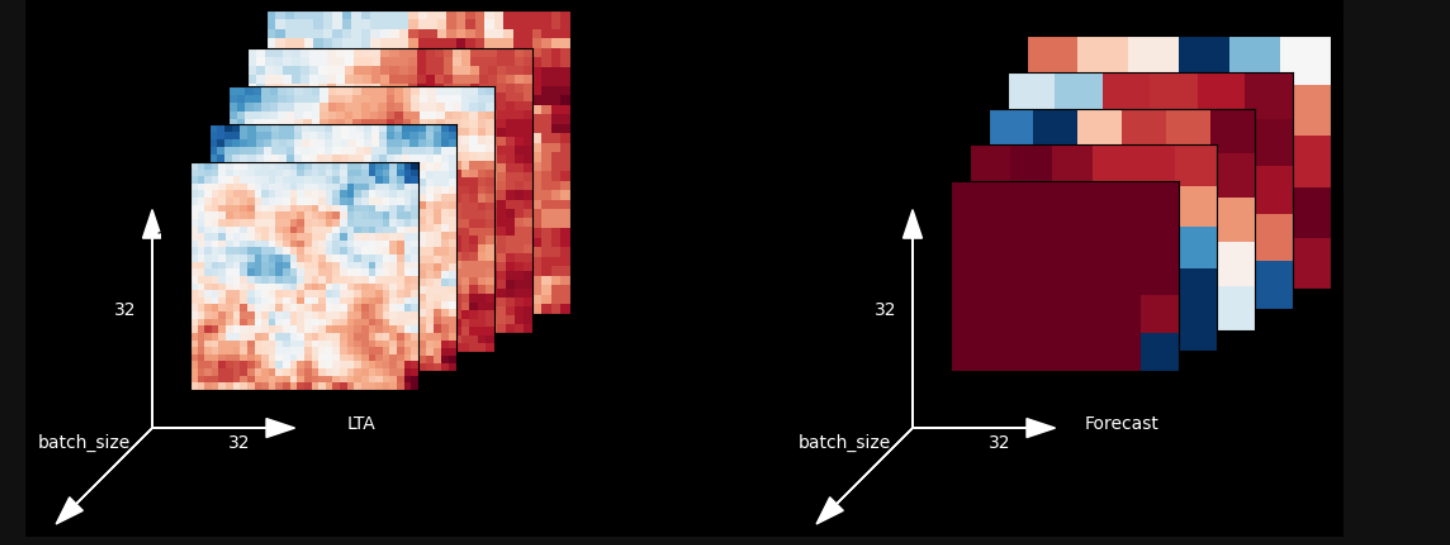


We will downscale every image  of 32 $\times$ 32 image and then reassamble the images to get a full image 96 $\times$ 64 between 2020 and 2022.

In [ ]:
for i in range(1,7):
    print(i)
    datamodule = ClimateDownscalingDataModule(root_dir=f'Data/Downscaling/Rainfall/Mozambique/Regions/region_{i}/data_npz/',
            variables=['forecast', 'rfh_lta'],
            out_variables=['rfh'],
            buffer_size= 2000,
            batch_size= batch_size
        )
    normalization = datamodule.transforms
    print(normalization)
    mean_norm, std_norm = normalization.mean, normalization.std
    mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
    model.set_denormalization(mean_denorm, std_denorm)
    model.set_lat_lon(*datamodule.get_lat_lon())

    denormalize_out = transforms.Normalize(datamodule.output_transforms.mean /datamodule.output_transforms.std , 1/datamodule.output_transforms.std)
    datamodule.setup()

    gt,pred,tensors,tensors_pred = climax_downscale(model, datamodule,mean_norm, std_norm, var_id = 1,year_to_select=2020)
    forecast, rfh_lta = tensors[0], tensors[1]
    
    save_path=  f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{i}"

    torch.save(gt, os.path.join(save_path, 'ground_truth_2020.pt'))
    torch.save(pred, os.path.join(save_path, 'pred_2020.pt'))
    torch.save(tensors, os.path.join(save_path, 'tensors_2020.pt'))
    torch.save(tensors_pred, os.path.join(save_path, 'tensors_pred_2020.pt'))
    
    
    gt,pred,tensors,tensors_pred = climax_downscale(model, datamodule,mean_norm, std_norm, var_id = 1,year_to_select=2021)
    forecast, rfh_lta = tensors[0], tensors[1]
    
    save_path=  f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{i}"

    torch.save(gt, os.path.join(save_path, 'ground_truth_2021.pt'))
    torch.save(pred, os.path.join(save_path, 'pred_2021.pt'))
    torch.save(tensors, os.path.join(save_path, 'tensors_2021.pt'))
    torch.save(tensors_pred, os.path.join(save_path, 'tensors_pred_2021.pt'))

1
Normalize(mean=[88.55359048 70.8184175 ], std=[69.1416717  34.53293019])


/home/u/wessim.omezzine/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Selected device: cpu
self.var_map=== {'forecast': 0, 'rfh_lta': 1, 'rfh': 2}


In [ ]:
for i in range(1, 7):
    save_path = f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{i}"

    # Construct the variable names
    gt_var_name = f"gt_{i}_2020"
    pred_var_name = f"pred_{i}_2020"
    tensors_var_name = f"tensors_{i}_2020"
    tensors_pred_var_name = f"tensors_pred_{i}_2020"

    # Load the saved tensors and assign them to the constructed variable names
    globals()[gt_var_name] = torch.load(os.path.join(save_path, 'ground_truth_2020.pt'))
    globals()[pred_var_name] = torch.load(os.path.join(save_path, 'pred_2020.pt'))
    globals()[tensors_var_name] = torch.load(os.path.join(save_path, 'tensors_2020.pt'))
    globals()[tensors_pred_var_name] = torch.load(os.path.join(save_path, 'tensors_pred_2020.pt'))
    
     # Construct the variable names
    gt_var_name = f"gt_{i}_2021"
    pred_var_name = f"pred_{i}_2021"
    tensors_var_name = f"tensors_{i}_2021"
    tensors_pred_var_name = f"tensors_pred_{i}_2021"

    # Load the saved tensors and assign them to the constructed variable names
    globals()[gt_var_name] = torch.load(os.path.join(save_path, 'ground_truth_2021.pt'))
    globals()[pred_var_name] = torch.load(os.path.join(save_path, 'pred_2021.pt'))
    globals()[tensors_var_name] = torch.load(os.path.join(save_path, 'tensors_2021.pt'))
    globals()[tensors_pred_var_name] = torch.load(os.path.join(save_path, 'tensors_pred_2021.pt'))


In [ ]:
gt_2020 = torch.cat([torch.cat([gt_1_2020, gt_2_2020, gt_3_2020], dim=3), torch.cat([gt_4_2020, gt_5_2020, gt_6_2020], dim=3)], dim=2)
gt_2021 = torch.cat([torch.cat([gt_1_2021, gt_2_2021, gt_3_2021], dim=3), torch.cat([gt_4_2021, gt_5_2021, gt_6_2021], dim=3)], dim=2)

pred_2020 = torch.cat([torch.cat([pred_1_2020, pred_2_2020, pred_3_2020], dim=3), torch.cat([pred_4_2020, pred_5_2020, pred_6_2020], dim=3)], dim=2)
pred_2021 = torch.cat([torch.cat([pred_1_2021, pred_2_2021, pred_3_2021], dim=3), torch.cat([pred_4_2021, pred_5_2021, pred_6_2021], dim=3)], dim=2)

forecast_2020 = torch.cat([torch.cat([tensors_1_2020[0], tensors_2_2020[0], tensors_3_2020[0]], dim=2), torch.cat([tensors_4_2020[0], tensors_5_2020[0], tensors_6_2020[0]], dim=2)], dim=1).unsqueeze(1)
forecast_2021 = torch.cat([torch.cat([tensors_1_2021[0], tensors_2_2021[0], tensors_3_2021[0]], dim=2), torch.cat([tensors_4_2021[0], tensors_5_2021[0], tensors_6_2021[0]], dim=2)], dim=1).unsqueeze(1)

lta_2020 = torch.cat([torch.cat([tensors_1_2020[1], tensors_2_2020[1], tensors_3_2020[1]], dim=2), torch.cat([tensors_4_2020[1], tensors_5_2020[1], tensors_6_2020[1]], dim=2)], dim=1).unsqueeze(1)
lta_2021 = torch.cat([torch.cat([tensors_1_2021[1], tensors_2_2021[1], tensors_3_2021[1]], dim=2), torch.cat([tensors_4_2021[1], tensors_5_2021[1], tensors_6_2021[1]], dim=2)], dim=1).unsqueeze(1)


In [ ]:
gt = torch.cat([gt_2020,gt_2021],dim=0)
pred = torch.cat([pred_2020,pred_2021],dim=0)
forecast = torch.cat([forecast_2020,forecast_2021],dim=0)
lta = torch.cat([lta_2020,lta_2021],dim=0)


In [ ]:
def bilinear_interpolate (forecast,t,verbose=False):
    new_height = forecast.shape[1]
    new_width = forecast.shape[2]
    forecast_resample=forecast[t]
    image_tensor  = forecast_resample[:30:5,:30:5]
    
    rescaled_image = F.interpolate(image_tensor.unsqueeze(0).unsqueeze(0), size=(new_height, new_width), mode='bilinear', align_corners=False)[0]
    
    if verbose:
        
        plt.imshow(rescaled_image)
        plt.show()
    
    
    
    return rescaled_image

In [ ]:
bilinear = torch.clone(forecast)
weighted= torch.clone(forecast)
for i in range(2):
    for j in range(3):        
        for t in range(gt.shape[0]):
            bilinear[t:t+1,0,32*(i):32*(i+1), 32*(j):32*(j+1)] = bilinear_interpolate(forecast[:,0,32*(i):32*(i+1), 32*(j):32*(j+1)],t)
            weighted[t,0,32*(i):32*(i+1), 32*(j):32*(j+1)] = torch.tensor(Downscale_Weight(lta[t,0,32*(i):32*(i+1), 32*(j):32*(j+1)].cpu().numpy(),forecast[t,0,32*(i):32*(i+1), 32*(j):32*(j+1)].cpu().numpy()))

In [ ]:
def tensor_to_xarray(tensor, ensemble,batch_size, path_to_data,lat_shape=96, long_shape=64, element_per_year=18, start_year=2020, end_year=2020):
    time = xr.open_dataset(os.path.join(path_to_data,"data/r1h_lta.nc")).time
    time_sorted = time['time'].sortby('time')
    time_axis = time_sorted
    time_axis = np.unique(time_axis.time.values)
    time_axis = time_axis[np.logical_and(time_axis >= np.datetime64(f'{start_year}-01-01'), time_axis < np.datetime64(f'{end_year}-12-31'))]
    
    latitude = np.arange(lat_shape)
    longitude = np.arange(long_shape)
    ensemble_indices =np.arange(ensemble)

    # Create an empty DataArray with the desired dimensions and coordinates
    tensor_xarray = xr.DataArray(
        np.empty((batch_size//ensemble, ensemble, lat_shape, long_shape)),  # Empty array with the desired shape
        coords={
            'time': time_axis,
            'latitude': latitude,
            'longitude': longitude,
            'ensemble': ensemble_indices,
        },
        dims=['time', 'ensemble', 'latitude', 'longitude'],
        name='band'
    )

    # Loop over ensembles and assign the corresponding data from gt
    for i in range(ensemble):
        start_index = i * element_per_year
        end_index = (i + 1) * element_per_year

        data = np.concatenate([tensor[start_index:end_index], tensor[start_index + element_per_year*ensemble:end_index + element_per_year*ensemble]], axis=0)

        # print(start_index, end_index,"        ",  start_index + 180, end_index + 180, "     ", start_index + 360, end_index + 360)
        # data = np.concatenate([gt[start_index:end_index], gt[start_index + 180:end_index + 180], gt[start_index + 360:end_index + 360]], axis=0)
        if len(data.shape) ==4:
            tensor_xarray[:,i] = data[:,0,:,:]
        else:
            tensor_xarray[:,i] = data[:,:,:]
            
    return tensor_xarray

In [ ]:
ensemble=20
region = 2
gt2020_xarray = tensor_to_xarray(gt[:360],ensemble,batch_size,path_to_data=f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{region}", lat_shape=64, long_shape=96, start_year=2020, end_year=2020)
pred2020_xarray = tensor_to_xarray(pred[:360],ensemble,batch_size,path_to_data=f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{region}", lat_shape=64, long_shape=96, start_year=2020, end_year=2020)
forecast2020_xarray = tensor_to_xarray(forecast[:360],ensemble,batch_size,path_to_data=f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{region}", lat_shape=64, long_shape=96, start_year=2020, end_year=2020)
lta2020_xarray = tensor_to_xarray(lta[:360],ensemble,batch_size,path_to_data=f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{region}", lat_shape=64, long_shape=96, start_year=2020, end_year=2020)
bilinear2020_xarray = tensor_to_xarray(bilinear[:360],ensemble,batch_size,path_to_data=f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{region}", lat_shape=64, long_shape=96, start_year=2020, end_year=2020)
weighted2020_xarray = tensor_to_xarray(weighted[:360],ensemble,batch_size,path_to_data=f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{region}", lat_shape=64, long_shape=96, start_year=2020, end_year=2020)



gt2021_xarray = tensor_to_xarray(gt[360:],ensemble,batch_size,path_to_data=f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{region}", lat_shape=64, long_shape=96, start_year=2021, end_year=2021)
pred2021_xarray = tensor_to_xarray(pred[360:],ensemble,batch_size,path_to_data=f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{region}", lat_shape=64, long_shape=96, start_year=2021, end_year=2021)
forecast2021_xarray = tensor_to_xarray(forecast[360:],ensemble,batch_size,path_to_data=f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{region}", lat_shape=64, long_shape=96, start_year=2021, end_year=2021)
lta2021_xarray = tensor_to_xarray(lta[360:],ensemble,batch_size,path_to_data=f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{region}", lat_shape=64, long_shape=96, start_year=2021, end_year=2021)
bilinear2021_xarray = tensor_to_xarray(bilinear[360:],ensemble,batch_size,path_to_data=f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{region}", lat_shape=64, long_shape=96, start_year=2021, end_year=2021)
weighted2021_xarray = tensor_to_xarray(weighted[360:],ensemble,batch_size,path_to_data=f"Data/Downscaling/Rainfall/Mozambique/Regions/region_{region}", lat_shape=64, long_shape=96, start_year=2021, end_year=2021)


In [ ]:
gt_xarray = xr.concat([gt2020_xarray, gt2021_xarray], dim='time')
pred_xarray = xr.concat([pred2020_xarray, pred2021_xarray], dim='time')

forecast_xarray = xr.concat([forecast2020_xarray, forecast2021_xarray], dim='time')
lta_xarray = xr.concat([lta2020_xarray, lta2021_xarray], dim='time')
bilinear_xarray = xr.concat([bilinear2020_xarray, bilinear2021_xarray], dim='time')
weighted_xarray = xr.concat([weighted2020_xarray, weighted2021_xarray], dim='time')


In [ ]:
import shutil
# Define the directory where to save the files
save_dir = f"Data/Downscaling/Rainfall/Mozambique/Regions/All_regions_xarrays"

# Remove all files in the directory
for filename in os.listdir(save_dir):
    file_path = os.path.join(save_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)
gt_xarray.to_netcdf(os.path.join(save_dir, 'gt_xarray.nc'))
pred_xarray.to_netcdf(os.path.join(save_dir, 'pred_xarray.nc'))
forecast_xarray.to_netcdf(os.path.join(save_dir, 'forecast_xarray.nc'))
lta_xarray.to_netcdf(os.path.join(save_dir, 'lta_xarray.nc'))
bilinear_xarray.to_netcdf(os.path.join(save_dir, 'bilinear_xarray.nc'))
weighted_xarray.to_netcdf(os.path.join(save_dir, 'weighted_xarray.nc'))


In [2]:
import xarray as xr

# Define the directory where the files are saved
save_dir = "Data/Downscaling/Rainfall/Mozambique/Regions/All_regions_xarrays"

# Create a dictionary to hold the data
data_dict = {}

gt_xarray = xr.open_dataarray(os.path.join(save_dir, f'gt_xarray.nc'))
pred_xarray = xr.open_dataarray(os.path.join(save_dir, f'pred_xarray.nc'))
forecast_xarray = xr.open_dataarray(os.path.join(save_dir, f'forecast_xarray.nc'))
lta_xarray=xr.open_dataarray(os.path.join(save_dir, f'lta_xarray.nc'))
bilinear_xarray=xr.open_dataarray(os.path.join(save_dir, f'bilinear_xarray.nc'))
weighted_xarray = xr.open_dataarray(os.path.join(save_dir, f'weighted_xarray.nc'))



In [3]:
gt_xarray

<xarray.DataArray 'band' (time: 36, ensemble: 20, latitude: 64, longitude: 96)>
[4423680 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-01-11 ... 2021-12-21
  * latitude   (latitude) int64 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
  * longitude  (longitude) int64 0 1 2 3 4 5 6 7 8 ... 88 89 90 91 92 93 94 95
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8 ... 11 12 13 14 15 16 17 18 19

In [8]:
datamodule = ClimateDownscalingDataModule(root_dir=f'Data/Downscaling/Rainfall/Mozambique/Regions/region_{1}/data_npz/',
            variables=['forecast', 'rfh_lta'],
            out_variables=['rfh'],
            buffer_size= 2000,
            batch_size= batch_size
        )

datamodule2 = ClimateDownscalingDataModule(root_dir=f'Data/Downscaling/Rainfall/Mozambique/Regions/region_{4}/data_npz/',
            variables=['forecast', 'rfh_lta'],
            out_variables=['rfh'],
            buffer_size= 2000,
            batch_size= batch_size
        )
lat = np.concatenate([datamodule.get_lat_lon()[0], datamodule2.get_lat_lon()[0]])

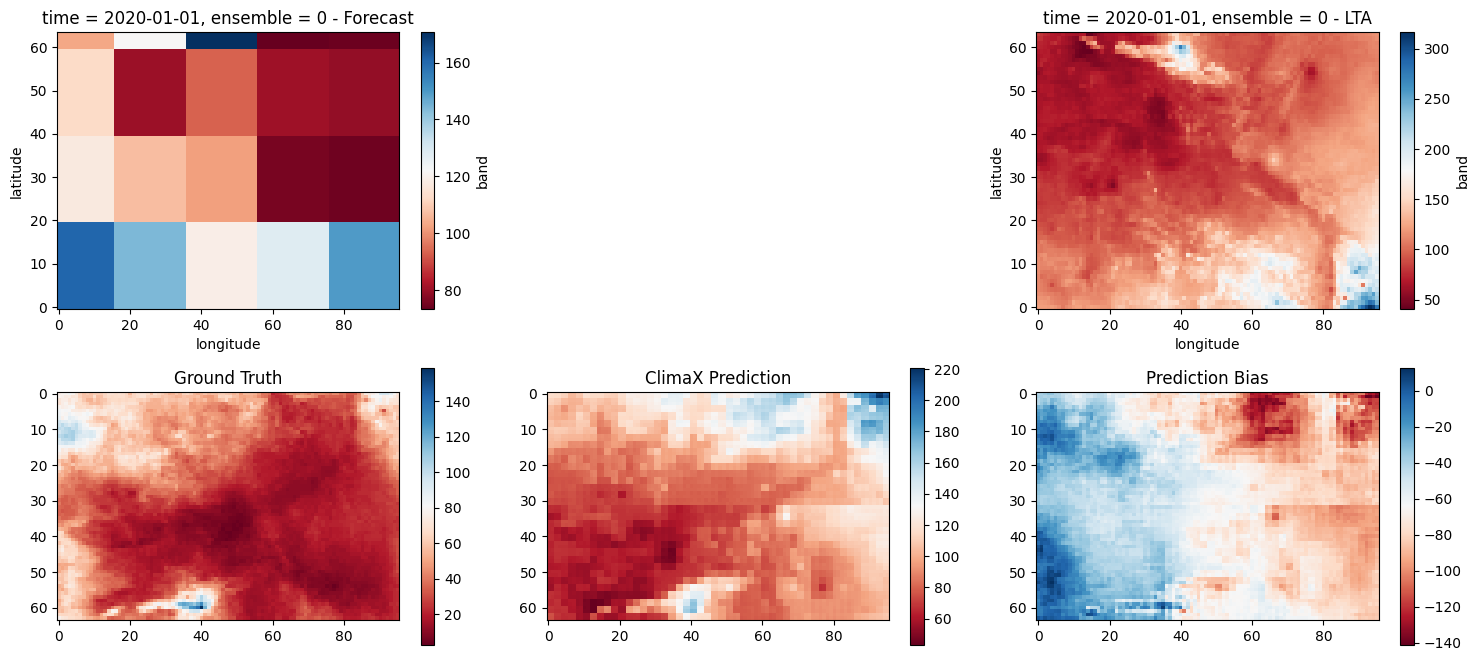

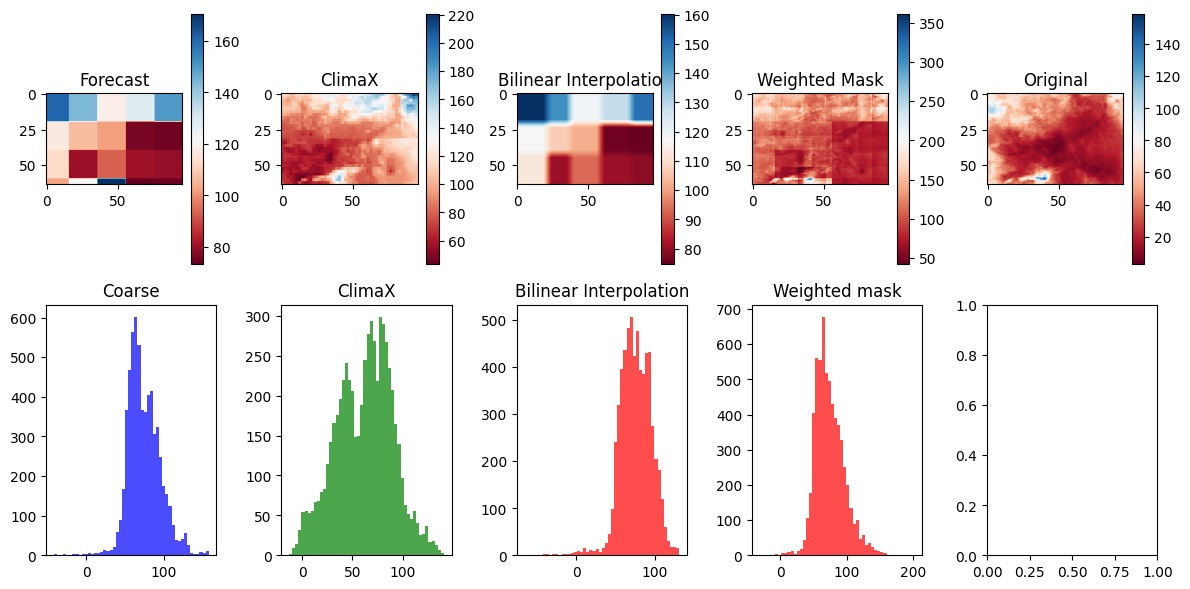

Selected device: cpu
+----------------------+--------------------+---------------------+------------------------+--------------------+
|                      | Coarse             | ClimaX              | Bilinear Interpolation | Weighted Mask      |
+----------------------+--------------------+---------------------+------------------------+--------------------+
| lat_weighted_mse_val | 5988.372512638394  | 4665.49980254717    | 6108.665748070564      | 6053.915150444759  |
| lat_weighted_rmse    | 77.38457541809217  | 68.30446400160952   | 78.157953837537        | 77.80690940041738  |
| spearman             | 0.63254392274426   | 0.31727794094504513 | 0.6383699100145667     | 0.6770960373106772 |
| mean_bias            | 74.43482237122953  | 62.27289785631001   | 75.52451797636847      | 74.52495153993368  |
| pearson              | 0.6586438836047614 | 0.33238679877279365 | 0.6553611628182812     | 0.7073778165367695 |
+----------------------+--------------------+---------------------+

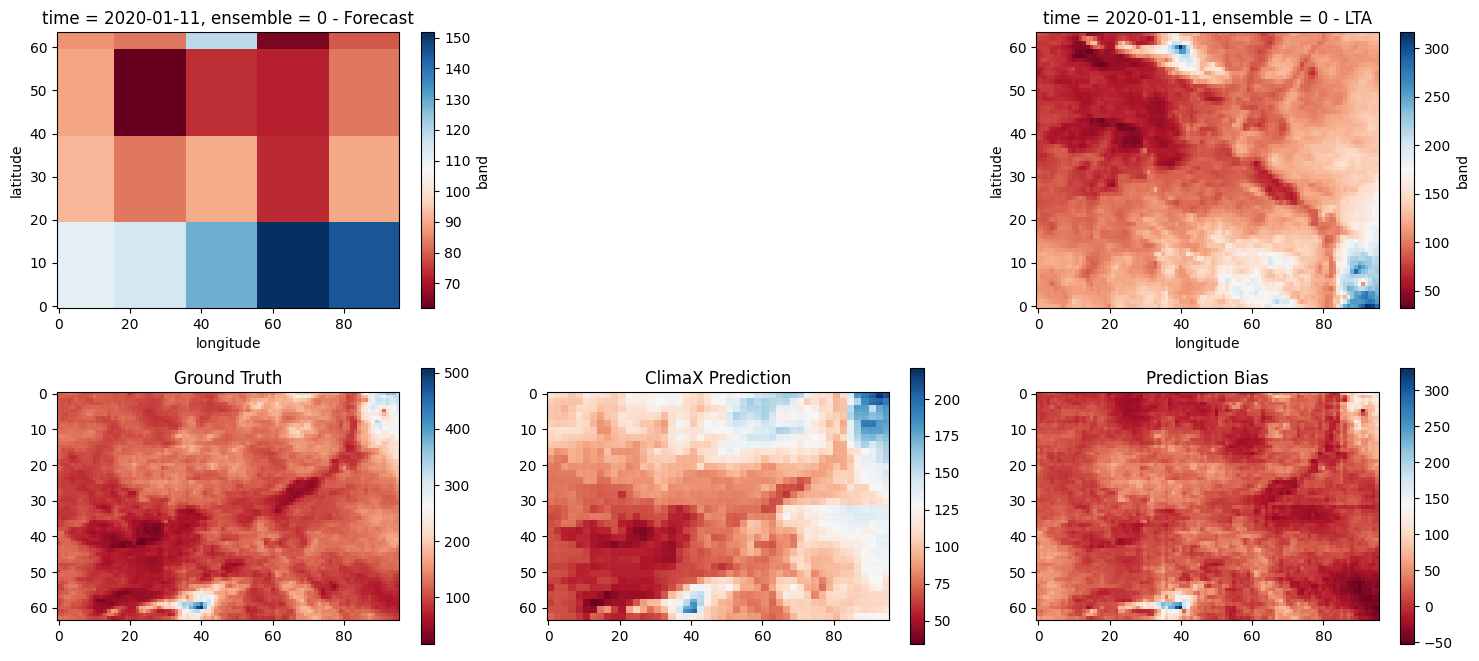

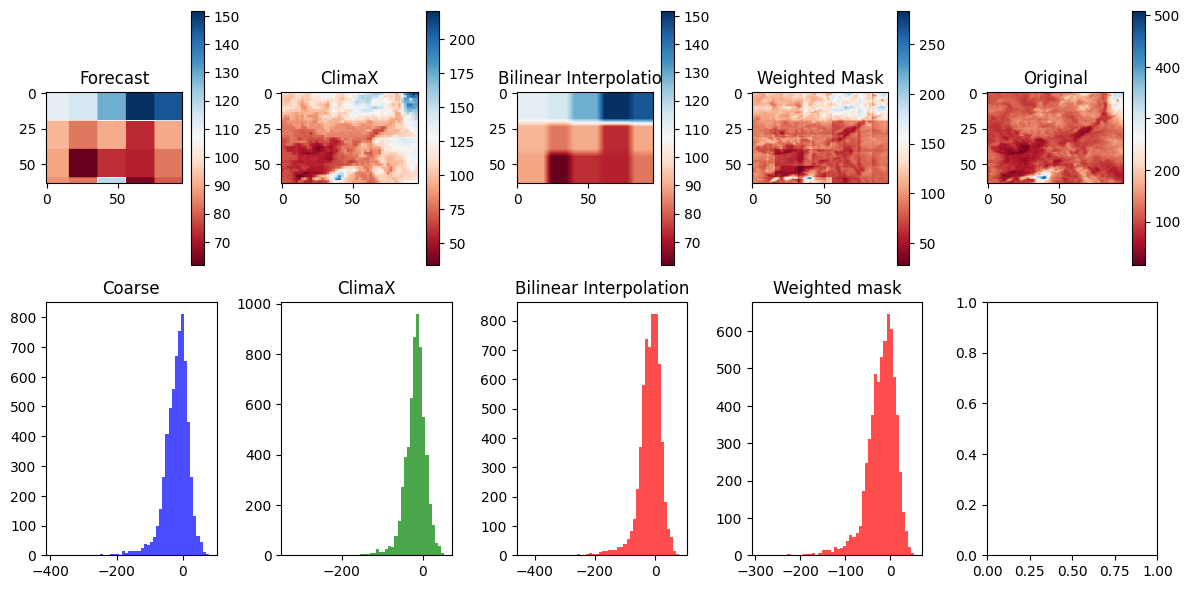

Selected device: cpu
+----------------------+---------------------+--------------------+------------------------+---------------------+
|                      | Coarse              | ClimaX             | Bilinear Interpolation | Weighted Mask       |
+----------------------+---------------------+--------------------+------------------------+---------------------+
| lat_weighted_mse_val | 1863.5332027637542  | 1105.5063314088447 | 1912.9234203267297     | 1508.0464183166223  |
| lat_weighted_rmse    | 43.16865996025073   | 33.24915534880314  | 43.73698000921794      | 38.83357333952958   |
| spearman             | 0.41333883293049467 | 0.7236386596644124 | 0.37878079837564127    | 0.5675785436499274  |
| mean_bias            | -19.448205889202654 | -19.10725455575934 | -18.642934113430485    | -19.312456427452474 |
| pearson              | 0.45253402656375374 | 0.7727749650817564 | 0.4084307056127659     | 0.6151367725241459  |
+----------------------+---------------------+-------------

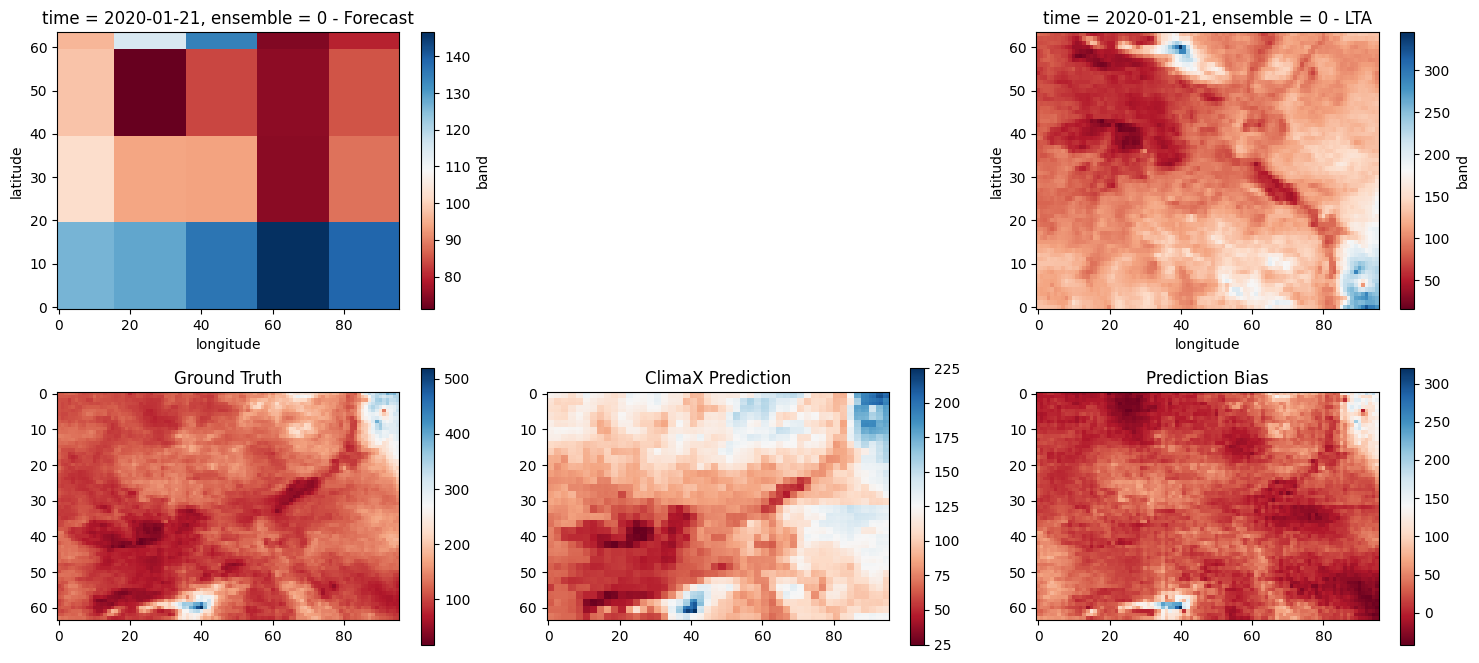

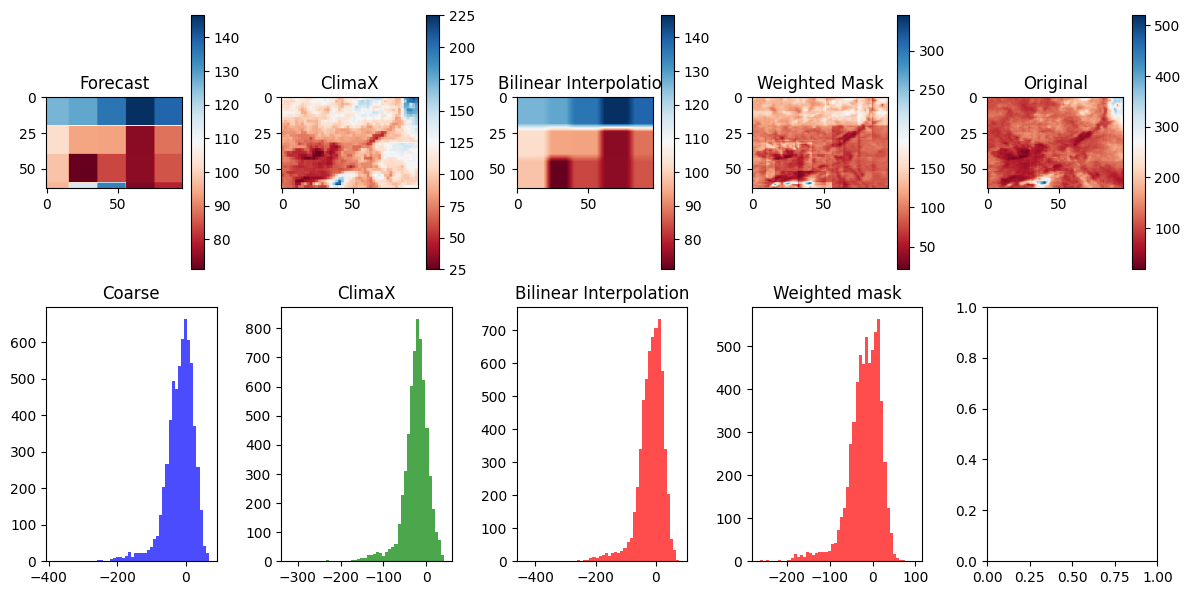

Selected device: cpu
+----------------------+---------------------+--------------------+------------------------+---------------------+
|                      | Coarse              | ClimaX             | Bilinear Interpolation | Weighted Mask       |
+----------------------+---------------------+--------------------+------------------------+---------------------+
| lat_weighted_mse_val | 2258.0128677738776  | 1550.2729772281643 | 2334.6517091401943     | 1829.868437332438   |
| lat_weighted_rmse    | 47.51855287962669   | 39.37350603169807  | 48.31823371295969      | 42.77696152524672   |
| spearman             | 0.380077602271965   | 0.7206262379127897 | 0.33145084491476096    | 0.5214260625757693  |
| mean_bias            | -18.510507131616265 | -24.8924069898203  | -17.8799829656879      | -18.254397426421434 |
| pearson              | 0.3984867978814657  | 0.7773267488660137 | 0.3488427856518993     | 0.580169032724481   |
+----------------------+---------------------+-------------

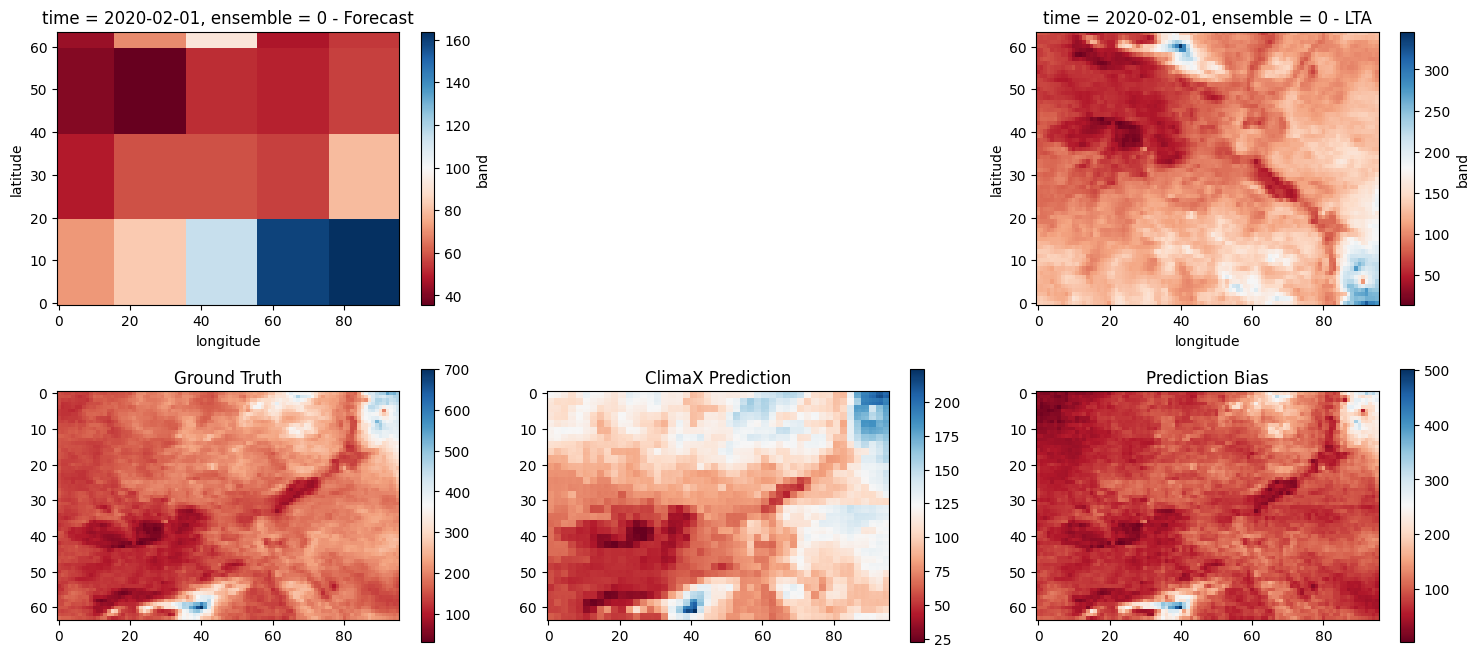

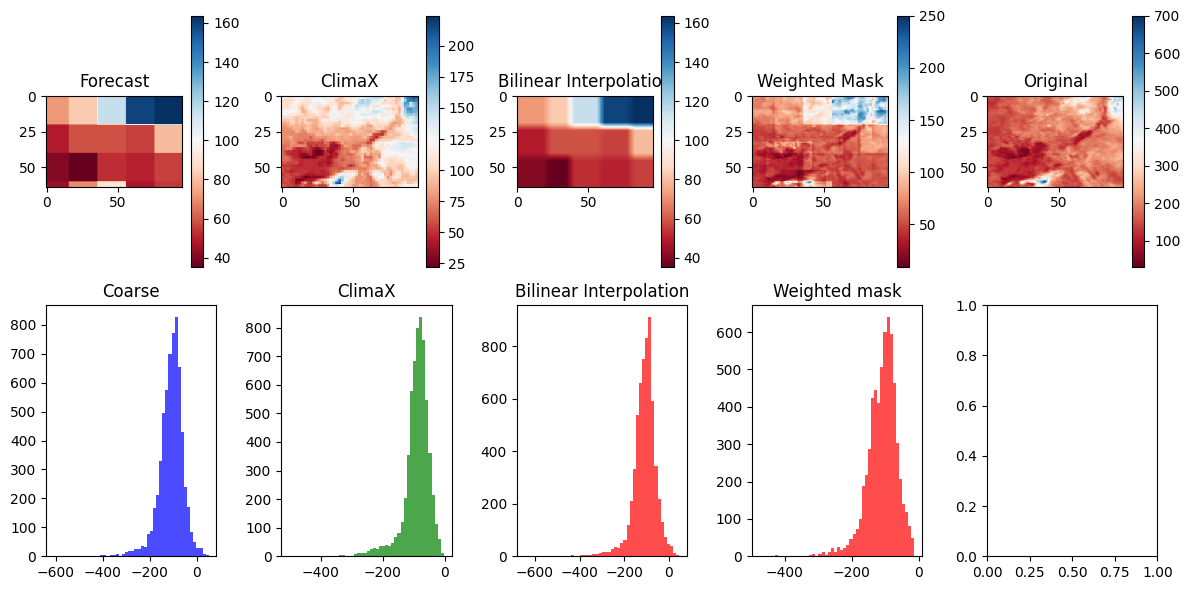

Selected device: cpu
+----------------------+---------------------+--------------------+------------------------+--------------------+
|                      | Coarse              | ClimaX             | Bilinear Interpolation | Weighted Mask      |
+----------------------+---------------------+--------------------+------------------------+--------------------+
| lat_weighted_mse_val | 14899.723035452298  | 10163.055505085564 | 15060.314154891668     | 14177.209018469104 |
| lat_weighted_rmse    | 122.06442166107328  | 100.81198096003055 | 122.72047162104482     | 119.0680856420775  |
| spearman             | 0.5526632716073672  | 0.837637781461961  | 0.5668958550941797     | 0.6850794882510131 |
| mean_bias            | -109.83183425913253 | -91.19450399527946 | -110.30428132104376    | -109.5949211224603 |
| pearson              | 0.5880497558308668  | 0.848314747344973  | 0.5762763014587227     | 0.7133134829811905 |
+----------------------+---------------------+--------------------+

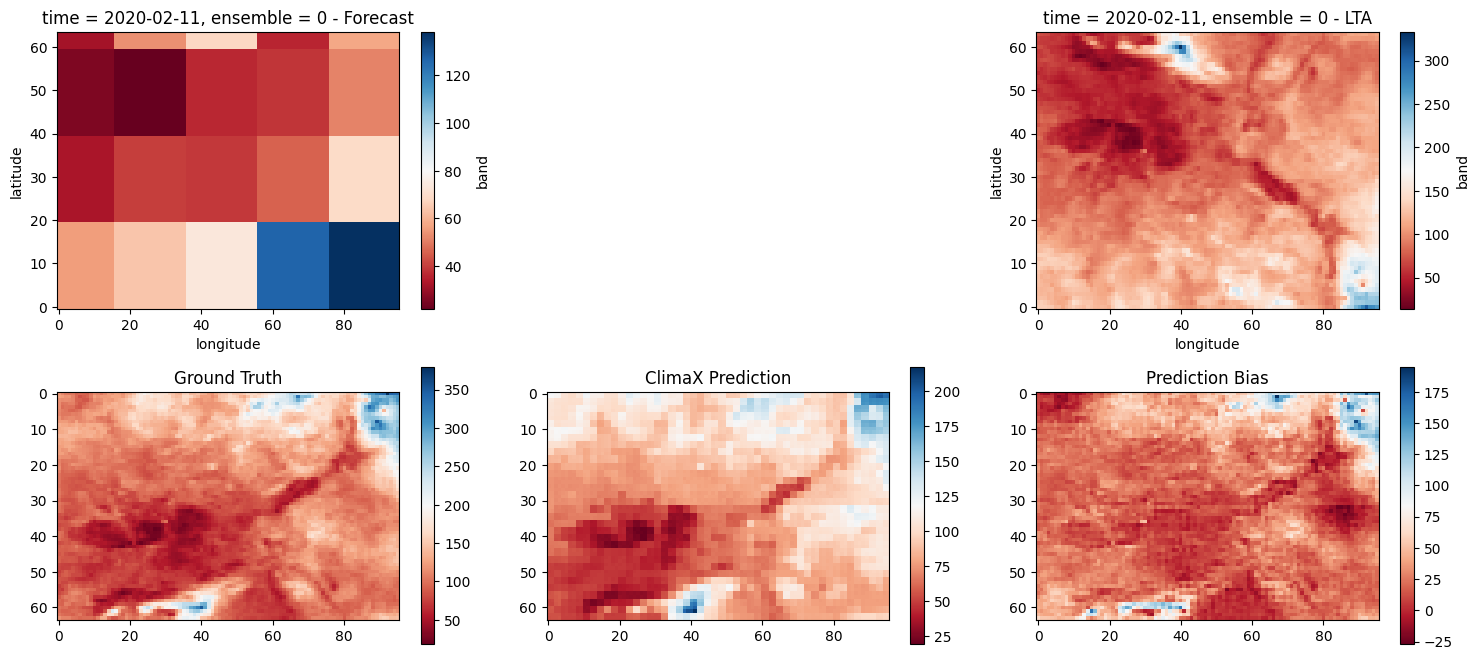

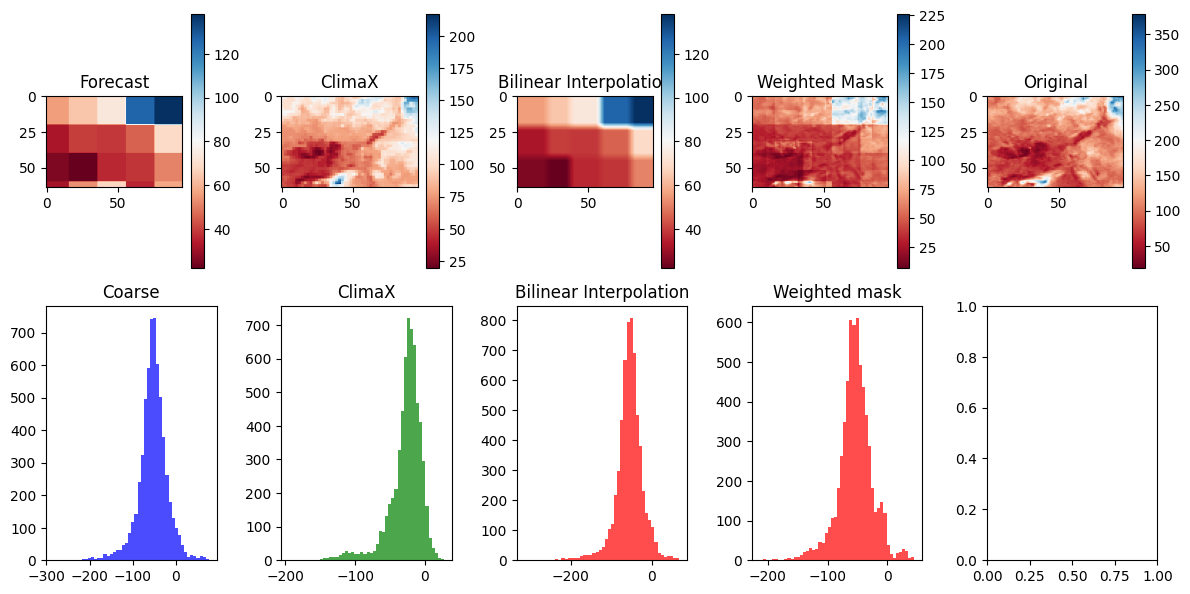

Selected device: cpu
+----------------------+--------------------+---------------------+------------------------+---------------------+
|                      | Coarse             | ClimaX              | Bilinear Interpolation | Weighted Mask       |
+----------------------+--------------------+---------------------+------------------------+---------------------+
| lat_weighted_mse_val | 4030.3531936079326 | 1385.9404418032254  | 4178.452434325762      | 3709.757970035817   |
| lat_weighted_rmse    | 63.48506275973847  | 37.2282210400017    | 64.64095013476954      | 60.90778250795063   |
| spearman             | 0.6934771929940694 | 0.8928700260876947  | 0.6812325622527832     | 0.786929783747432   |
| mean_bias            | -53.77460893522949 | -27.763523558154702 | -54.82135434479763     | -53.567257504599795 |
| pearson              | 0.6654723793385543 | 0.880402572782636   | 0.6516113959315639     | 0.7661462164808099  |
+----------------------+--------------------+--------------

In [10]:
for member in range(1):
    for t in range(5):
        visualize_climax(forecast_xarray, lta_xarray, gt_xarray, pred_xarray, bilinear_xarray, weighted_xarray, t, member)
        compare_results(gt_xarray, forecast_xarray, pred_xarray, bilinear_xarray, weighted_xarray, lat,t,member,denormalize_out)


## seasonality

### Introduction
This section delves into a comprehensive analysis of various downscaling methods. The aim is to compare these methods in terms of how closely they approximate ground truth data. By analyzing the relationships between coarse ECMWF data, Long-Term Average (LTA), and outputs from different downscaling approaches, we enhance our understanding and predictive capabilities regarding seasonal climate variations.

### Objective
Our objective is to identify which downscaling method most accurately reflects the ground truth data. This analysis is crucial for improving the precision and reliability of seasonal climate predictions.

### Methodology
The methodology for this analysis includes:

1. Data Compilation: Collection of ECMWF data along with downscaling outputs from various methods.
2. Comparative Analysis: Examination of the relationships between the coarse ECMWF data, LTA, and the outputs from different downscaling methods.
3. Seasonality Assessment: Focus on how each downscaling method captures seasonal variations in the data.
### Analysis
* Downscaling Comparison: Compare the performance of different downscaling methods like ClimaX, Bilinear, Weighted, and others.
* Statistical Evaluation: Utilize statistical tools to evaluate how closely each method approximates ground truth data.
### Importance
Understanding which downscaling method provides the most accurate representation of ground truth data is essential for sectors that rely heavily on seasonal climate predictions, such as agriculture, environmental planning, and disaster management. This analysis aids in enhancing the precision of climate models, thereby improving decision-making and planning processes.

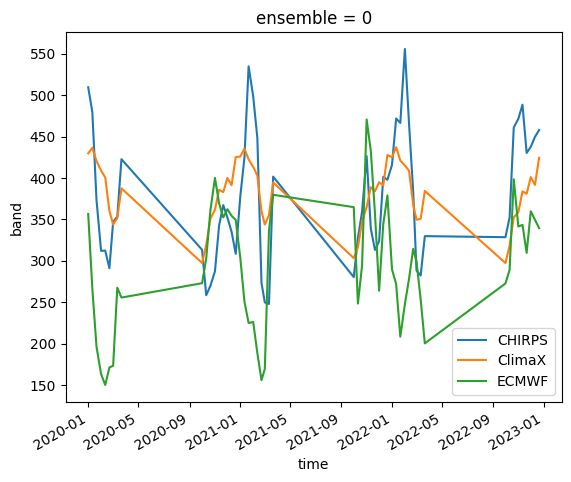

In [33]:

# gt_xarray.isel(ensemble=1,latitude=0,longitude=0).plot.line(label="CHIRPS")
(gt_xarray.isel(ensemble=0).mean(dim=['latitude', 'longitude'])).plot.line(label="CHIRPS")
(pred_xarray.isel(ensemble=0).mean(dim=['latitude', 'longitude'])).plot.line(label="ClimaX")
(forecast_xarray.isel(ensemble=0).mean(dim=['latitude', 'longitude'])).plot.line(label="ECMWF",)
# (lta_xarray.isel(ensemble=0).mean(dim=['latitude', 'longitude'])).plot.line(label="LTA")
# (weighted_xarray.isel(ensemble=0).mean(dim=['latitude', 'longitude'])).plot.line(label="Weighted")
# (bilinear_xarray.isel(ensemble=0).mean(dim=['latitude', 'longitude'])).plot.line(label="Bilinear")
# LTA_xarray.isel(ensemble=0,latitude=0,longitude=0).plot.line(label="LTA")
plt.legend()


## Variability Between Members

### Introduction
The European Centre for Medium-Range Weather Forecasts (ECMWF) organizes its forecast data into different 'members' or ensemble forecasts. Each member represents a possible state of the atmosphere, providing a range of outcomes that helps in assessing the uncertainty of weather predictions.

### Objective
In this section, we focus on studying the variability between these members. Our aim is to understand whether the variability observed within the ensemble members is retained after the downscaling process, which is crucial for maintaining the forecast's uncertainty characteristics.

### Methodology
To examine this, we follow a systematic approach:
1. **Data Collection**: We gather the forecast data from multiple ECMWF members for a specific time frame.
2. **Downscaling**: Each member's data is downscaled using the ClimaX model.
3. **Assessment of Variability**: We compare the downscaled results to assess the degree of variability between members.

#### Analysis
- **Consistency Check**: We check whether the spread of outcomes in the downscaled data reflects the spread in the original ECMWF ensemble.
- **Statistical Measures**: We employ statistical measures to quantify the variability, such as the standard deviation and interquartile range among the members.

### Importance
This analysis is significant as it provides insights into the reliability of the downscaling process. Retaining variability is essential for accurate risk assessment in sectors sensitive to weather variability, such as agriculture, energy, and disaster management.




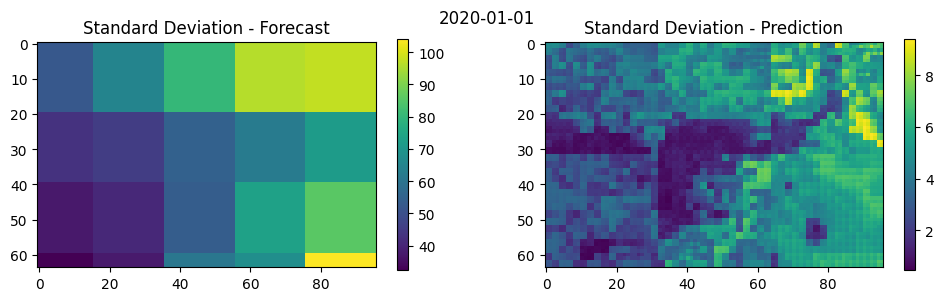

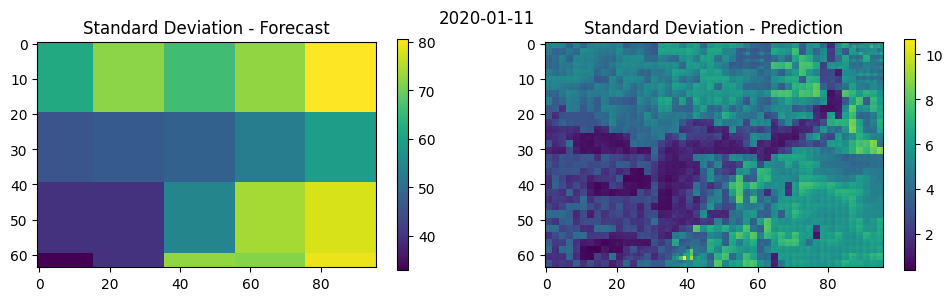

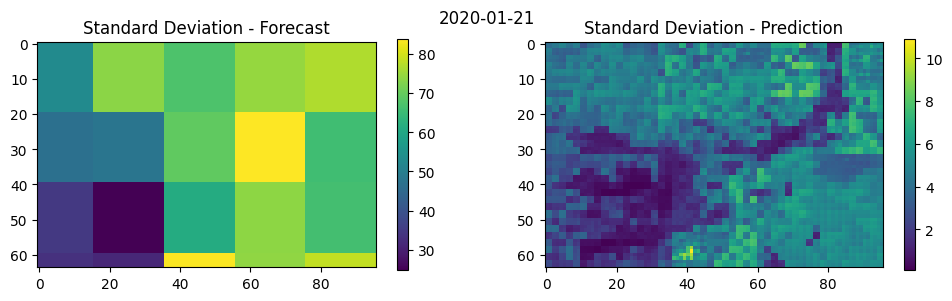

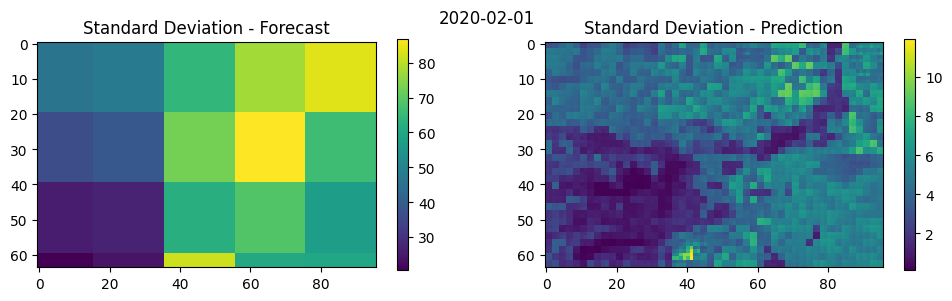

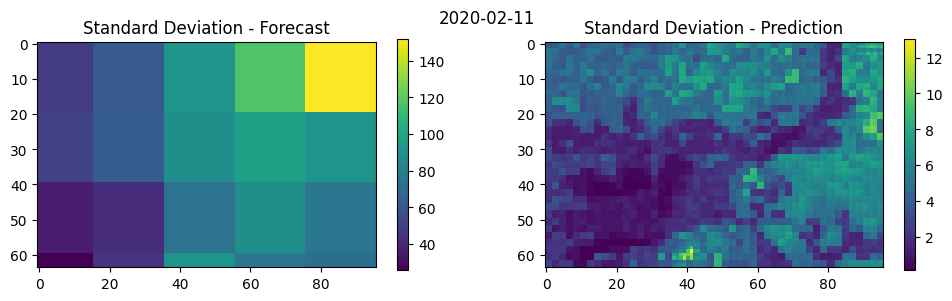

In [4]:
import xarray as xr
import matplotlib.pyplot as plt

# Assuming your data is stored in the 'pred_xarray' variable

for t in range(5):
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    
    # Plot the standard deviation for the current time step
    std_deviation = forecast_xarray.isel(time=t).std(dim='ensemble')
    im0 = axs[0].imshow(std_deviation)
    axs[0].set_title(f'Standard Deviation - Forecast')
    cbar0 = plt.colorbar(im0, ax=axs[0])  # Add colorbar for the first subplot
    
    # Plot the original data for the current time step (adjust as needed)
    original_data = pred_xarray.isel(time=t).std(dim='ensemble')
    im1 = axs[1].imshow(original_data)
    axs[1].set_title("Standard Deviation - Prediction")
    cbar1 = plt.colorbar(im1, ax=axs[1])  # Add colorbar for the second subplot
    
    # Set the title of the entire figure
    plt.suptitle(pred_xarray.isel(time=t).time.values.astype('datetime64[D]'))
    
    plt.show()
